In [3]:
from astropy import units as u
from plasmapy.formulary.parameters import plasma_frequency, Debye_length

import directsolver

from functools import partial
from importlib import reload

reload(directsolver)
import util
reload(util)
from util.MTSI  import eps_MTSI
from util.iaw import eps_IAW, analytic_IAW, analytic_IAW_simple,first_guess
from directsolver import solvekys
from scipy import optimize

import matplotlib.pyplot as plt
import numpy as np
from astropy.constants import m_e, m_p
me = m_e.value
mi = 131*m_p.value

In [4]:
Te = 10*u.eV
plasmaDensity=1e16 *u.m**(-3)

In [5]:
from util.parameters import PlasmaParameters

In [6]:
pp = PlasmaParameters(plasmaDensity=plasmaDensity, electronTemperature=Te)

In [7]:
pp.Debye_length

<Quantity 0.00023508 m>

In [8]:
pp.ionPlasmaFrequency

<Quantity 11531653.95287732 rad / s>

In [9]:
pp.ionPlasmaFrequency/(2*np.pi*u.rad)

<Quantity 1835319.72862562 1 / s>

In [10]:
pp.BohmSpeed

<Quantity 2710.88297111 m / s>

In [11]:
pp.driftSpeed

<Quantity 50000000. m / s>

# Compute

In [12]:
kx = 0.0
kz = 0.0
prt=PlasmaParameters(plasmaDensity=1e17/u.m**3,
                     electronTemperature=20*u.eV,
                     magneticField=0.02*u.T,
                     electricField=4e4*u.V/u.m,
                     ionTemperature=0.01*u.eV)



plasmaEps = partial(eps_IAW, prt=prt)

wrfunct = lambda k: analytic_IAW(k, ti=prt.ionTemperature/ prt.electronTemperature)

kysref, xsref = solvekys(plasmaEps, kx=kx, kz=kz, kymin=0.1, kymax=6,
                         parall=False, wrfunct=wrfunct, Nkys=30)


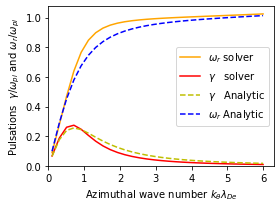

In [13]:

# plot
fig = plt.figure(figsize=(4,3))
plt.plot(kysref, xsref[:,0], "orange", label="$\omega_r$ solver")
plt.plot(kysref, xsref[:,1], "red", label="$\gamma$   solver")

plt.plot(kysref, prt.driftSpeed/prt.BohmSpeed* np.sqrt(me/mi)*np.sqrt(np.pi/8)*kysref/(1 + kysref**2)**(3/2), "y--", label="$\gamma$   Analytic")
plt.plot(kysref, analytic_IAW(kysref, ti=prt.ionTemperature/ prt.electronTemperature), "b--", label="$\omega_r$ Analytic")


plt.legend()
plt.xlabel("Azimuthal wave number $k_{\\theta} \\lambda_{De}$")
plt.ylabel("Pulsations  $\\gamma/\\omega_{pi}$ and $ \\omega_r/\\omega_{pi} $")
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()

### Conlcusion

The solver reproduce almost the analytique dispertion relation for the Ion Accoustic wave.
The origine of the discrepency is yet to me found

#  Modified Two Streams Instability

The dispertion relation of the Modified Two Streams Instability (MTSI) is rather simple, as no Fedevaa function is used.

However, there is no Analytic solution, yet.

# Compute

In [90]:
#calculate kz

kx = 0.0
# kz = 0.005
prt=PlasmaParameters(plasmaDensity=5e16/u.m**3,
                     electronTemperature=10*u.eV,
                     magneticField=0.02*u.T,
                     electricField=1e4*u.V/u.m,
                     ionTemperature=0.5*u.eV)

Lr = 0.0128*u.m
kz = 2*np.pi*prt.Debye_length/Lr
kz = 0.0045
print("kz =",kz)

kz = 0.0045


In [91]:
plasmaEps = partial(eps_MTSI, prt=prt) #assign to the function eps_MTSI the value of prt from now on

# we still use the IAW as a first guess
# wrfunct = lambda k: analytic_IAW(k, ti=prt.ionTemperature/ prt.electronTemperature)

# different first guess
# USE ONLY WITH kymin=0.01, kymax=2, Nkys=200
wrfunct = lambda k: first_guess(k)

kysref1, xsref1 = solvekys(plasmaEps, kx=kx, kz=kz, kymin=0.01, kymax=2,
                         parall=False, wrfunct=wrfunct,Nkys=200)


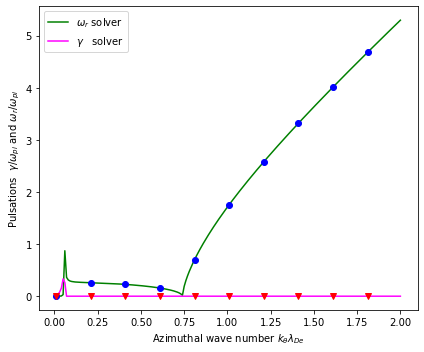

In [98]:

# plot
fig = plt.figure(figsize=(6,5))
# plt.plot(kysref, xsref[:,0], "b", label="$\omega_r$ solver old")
# plt.plot(kysref, xsref[:,1], "red", label="$\gamma$   solver old")
plt.plot(kysref1, xsref1[:,0], "green", label="$\omega_r$ solver")
plt.plot(kysref1, xsref1[:,1], "magenta", label="$\gamma$   solver")

# plt.plot(kysref, prt.driftSpeed/prt.BohmSpeed* np.sqrt(me/mi)*np.sqrt(np.pi/8)*kysref/(1 + kysref**2)**(3/2), "r--", label="$\gamma$ IAW  Analytic")
# plt.plot(kysref, analytic_IAW(kysref, ti=prt.ionTemperature/ prt.electronTemperature), "b--", label="$\omega_r$ IAW Analytic")


plt.legend()
plt.xlabel("Azimuthal wave number $k_{\\theta} \\lambda_{De}$")
plt.ylabel("Pulsations  $\\gamma/\\omega_{pi}$ and $ \\omega_r/\\omega_{pi} $")
#plt.xlim(left=0)
#plt.ylim(bottom=0)

plt.tight_layout()

for i in range(10):
    plt.plot(kysref1[i*20],wrfunct(kysref1[i*20]).real,"o",color='blue')
    plt.plot(kysref1[i*20],wrfunct(kysref1[i*20]).imag,"v",color='red')

# for i in range(200):
#     plt.plot(kysref1[i],wrfunct(kysref1[i]).real,"o",color='blue')
#     plt.plot(kysref1[i],wrfunct(kysref1[i]).imag,"v",color='red')

# plt.plot(kysref1,wrfunct(kysref1))

In [93]:
# f = open("dispersion1.txt","w+")

# f.write("kz: "+ str(kz) + "\r\n")
# f.write("plasma density: " + str(prt.plasmaDensity)+"\r\n")
# f.write("Te: " + str(prt.electronTemperature)+"\r\n")
# f.write("E field: " + str(prt.electricField)+"\r\n"+ "\r\n")


# f.write("ky: ")
# for i in range(len(kysref1)):
#     f.write(str(kysref1[i]) + ",  ")
# f.write("\r\n" + "\n" + "omega_r: ")
# for i in range(len(kysref1)):
#     f.write(str(xsref1[i,0]) + ",  ")
# f.write("\r\n" + "\n" + "gamma: " )
# for i in range(len(kysref1)):
#     f.write(str(xsref1[i,1]) + ",  ")
# f.write("\r\n" )